# Phase 1: Create a Word-Embedding layer 

In [145]:
#imports
from flair.embeddings import WordEmbeddings
from flair.data import Sentence
import networkx as nx
import torch

In [146]:
def read_data(datafile):
    with open(datafile) as f:
        lines = f.readlines()
    return lines

In [147]:
glove_embedding = WordEmbeddings('glove')
words = read_data('../data/vertomul.txt')
words = [line.strip() for line in open('../data/vertomul.txt')]

In [148]:
word_emb = {}
for word in words:
    sentence = Sentence(word) # --> strip() removes the white space from beginning and end of word
     # embed a sentence using glove.
    glove_embedding.embed(sentence)
    for token in sentence:

        word_emb[word]=token.embedding
    

###  We decided to compute the distance using cosine similarity

In [149]:
G = nx.Graph()

In [150]:
G.add_nodes_from(words)

In [151]:
len(list(G.nodes))

529

A similarity of 1 means that the words are the same.
Cosine similarity value smaller than 80 makes the edges increase by a lot. 

In [152]:
for item in word_emb:
    x = word_emb[item]
    
    for word in word_emb:
        if word is not item:
            y = word_emb[word]
            cosine_sim = torch.cosine_similarity(x.unsqueeze(0), y.unsqueeze(0))
            
            if cosine_sim > .8:
                G.add_edge(item, word)
#             print("x:", item, "y:", word, "distance: ", cosine_sim)

In [153]:
G.number_of_nodes()

529

In [154]:
G.number_of_edges()

246

### Mean clustering coefficient (CC)

In [156]:
print(nx.average_clustering(G))

0.06606594537207236


### Assortativity coefficient (a)

In [157]:
nx.degree_assortativity_coefficient(G)

0.4112425700024269

### Mean degree of connectivity (k)

In [162]:
conn_degree = nx.average_degree_connectivity(G)
conn_degree.values()

dict_values([2.473684210526316, 0, 7.5, 9.2, 3.225, 9.408163265306122, 9.071428571428571, 9.233333333333333, 7.428571428571429, 10.88888888888889, 6.333333333333333, 10.153846153846153, 10.5, 9.4375, 9.242424242424242, 9.722222222222221, 10.8125, 9.0])

In [164]:
sum_val = 0
for val in conn_degree.values():
    sum_val += val

mean_degree_connectivity = sum_val / len(conn_degree.values())
mean_degree_connectivity

7.9794942027711455

### Largest Connected Component (Conn)

In [139]:
largest_cc = max(nx.connected_components(G), key=len)
len(largest_cc)

71

In [167]:
conn = 71/G.number_of_nodes()
conn

0.1342155009451796

### Mean shortest path length of the largest connected component <_d_>

In [180]:
largest_cc = nx.complete_graph(largest_cc)
type(largest_cc)

networkx.classes.graph.Graph

In [179]:
print(nx.average_shortest_path_length(largest_cc))

1.0


The graph is not connected 

In [96]:
print(nx.is_connected(G))

False


Nodes with higher closeness centrality are better connected with the rest of the nodes. I am assuming that nodes with a closeness centrality equal to zero are not connected to any other node. 

In [97]:
word_emb_cc = nx.closeness_centrality(G)

# Multiplex Network - 4 layers 

## Get the data for the 4 layers in the multiplex

In [98]:
phonological_sim_words = [line.strip() for line in open('../data/phcmul.txt')]
feature_sharing_words = [line.strip() for line in open('../data/mrmul.txt')]
free_association_words = [line.strip() for line in open('../data/famul.txt')]
co_occurrances_words = [line.strip() for line in open('../data/cumul.txt')]

## Clean up the data and store it into a list

In [99]:
phonological_sim_list = []
feature_sharing_list = []
free_association_list = []
co_occurrances_list = []

for pair in phonological_sim_words:
    phonological_sim_list.append(tuple(map(str, pair.split('\t'))))
    
for pair in feature_sharing_words:
    feature_sharing_list.append(tuple(map(str, pair.split('\t'))))
    
for pair in free_association_words:
    free_association_list.append(tuple(map(str, pair.split('\t'))))
    
for pair in co_occurrances_words :
    co_occurrances_list.append(tuple(map(str, pair.split('\t'))))


## Instantiate another graph for the multiplex

In [100]:
multiplex = nx.Graph()

In [101]:
multiplex.add_nodes_from(words)

In [102]:
len(list(multiplex.nodes))

529

Adding the phonological connections to the graph

In [103]:
for pair in phonological_sim_list:
    multiplex.add_edge(pair[0], pair[1])
    

In [104]:
len(list(multiplex.nodes))

529

In [105]:
multiplex.number_of_edges()

349

Adding the feature sharing connections to the graph

In [106]:
for pair in feature_sharing_list:
    multiplex.add_edge(pair[0], pair[1])

In [107]:
len(list(multiplex.nodes))


529

In [108]:
multiplex.number_of_edges()

2732

Adding the free association connections to the graph

In [109]:
for pair in free_association_list:
    multiplex.add_edge(pair[0], pair[1])

In [110]:
multiplex.number_of_edges()

5001

Adding the cooccurrances connections to the graph

In [111]:
for pair in co_occurrances_list:
    multiplex.add_edge(pair[0], pair[1])

In [112]:
multiplex.number_of_edges()

6998

##  The original multiplex layer has been constucted. 

In [113]:
# computes the difference between the multiplex and the word-embedding layer
print(multiplex.number_of_nodes())
print(G.number_of_nodes())

529
529


In [114]:
print(nx.average_clustering(multiplex))

0.3279300913138615


In [129]:
nx.degree_assortativity_coefficient(multiplex)

-0.16446899275620427

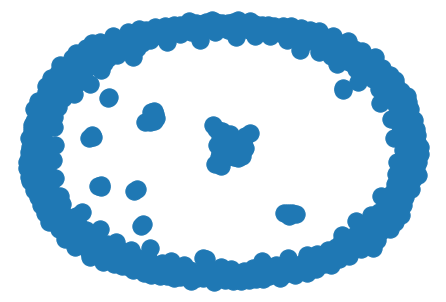

In [115]:
nx.draw(G, pos=nx.spring_layout(G))

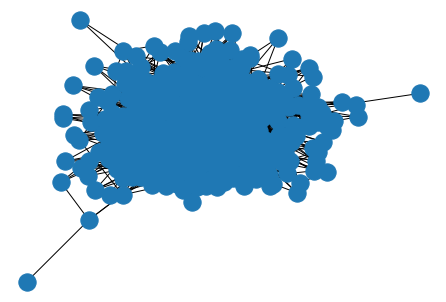

In [116]:
nx.draw(multiplex, pos=nx.spring_layout(multiplex))

In [117]:
multiplex_copy = multiplex.copy()
multiplex_copy.remove_edges_from(n for n in multiplex if n not in G)


In [118]:
multiplex_copy.number_of_edges()

6998

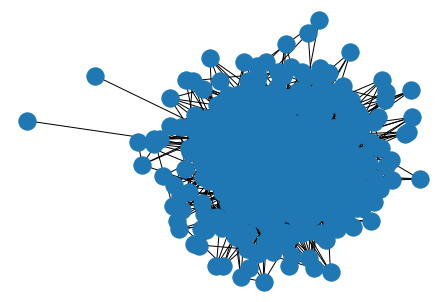

In [119]:
nx.draw(multiplex_copy, pos=nx.spring_layout(multiplex_copy))

In [120]:
multiplex_cc = nx.closeness_centrality(multiplex)

In [121]:
print(nx.is_connected(multiplex))

True


# Now, we add the visual layer to the multiplex

In [122]:
visual_words = [line.strip().replace('"', "") for line in open('../data/wac_clip_freechild.txt')]

In [123]:
visual_list = []

for pair in visual_words:   
    visual_list.append(tuple(map(str, pair.split('->'))))

In [192]:
visual_graph = nx.Graph()

In [194]:
visual_graph.add_nodes_from(words)
visual_graph.number_of_nodes()

529

In [195]:
for pair in visual_list:
    visual_graph.add_edge(pair[0], pair[1])

In [131]:
for pair in visual_list:
    multiplex.add_edge(pair[0], pair[1])

### Mean degree of connectivity

In [181]:
conn_degree_multiplex = nx.average_degree_connectivity(multiplex)
conn_degree_multiplex.values()

dict_values([38.15458937198068, 33.654761904761905, 44.4375, 38.80603448275862, 54.708333333333336, 42.58510638297872, 58.531007751937985, 44.142857142857146, 51.736, 52.54054054054054, 40.92181069958848, 50.90952380952381, 39.077777777777776, 12.2, 35.366379310344826, 48.785714285714285, 52.878787878787875, 57.775510204081634, 55.607594936708864, 44.67094017094017, 52.853968253968254, 42.253571428571426, 43.5859375, 53.24652777777778, 34.3125, 43.16477272727273, 52.43518518518518, 46.84931506849315, 57.657407407407405, 51.7060606060606, 33.47857142857143, 48.321739130434786, 50.19277108433735, 76.23977900552487, 60.177083333333336, 53.969348659003835, 60.16, 38.09230769230769, 41.207692307692305, 52.445454545454545, 58.725, 49.458, 49.537254901960786, 56.07692307692308, 52.86666666666667, 49.954081632653065, 49.199095022624434, 43.53260869565217, 53.56410256410256, 27.4375, 28.846153846153847, 49.582857142857144, 60.50819672131148, 50.8771186440678, 34.96491228070175, 52.3541666666666

In [197]:
sum_val = 0
for val in conn_degree_multiplex.values():
    sum_val += val

mean_degree_connectivity = sum_val / len(conn_degree_multiplex.values())
mean_degree_connectivity

44.75520231996821

In [196]:
conn_degree_visual = nx.average_degree_connectivity(visual_graph)
conn_degree_visual.values()

dict_values([0, 79.27893175074183, 4.944827586206896, 4.872340425531915, 5.0, 4.911111111111111, 4.931034482758621, 4.962085308056872, 5.0, 5.0, 4.9625, 5.0, 5.0, 4.888888888888889, 4.923076923076923, 4.962264150943396, 4.971830985915493, 28.782608695652176, 4.961904761904762, 4.78125, 5.0, 5.0, 11.604651162790697, 4.869565217391305, 5.0, 4.916666666666667, 5.0, 11.466666666666667, 4.888888888888889, 35.825, 5.0, 4.785714285714286, 5.0, 5.0, 5.0, 5.0])

In [198]:
sum_val = 0
for val in conn_degree_visual.values():
    sum_val += val

mean_degree_connectivity = sum_val / len(conn_degree_visual.values())
mean_degree_connectivity

8.763661332191871

### Mean clustering coefficient

In [184]:
print(nx.average_clustering(multiplex))

0.1731287607834658


In [202]:
print(nx.average_clustering(visual_graph))

0.0


### Assortativity coefficient

In [185]:
nx.degree_assortativity_coefficient(multiplex)

-0.16446899275620427

In [203]:
nx.degree_assortativity_coefficient(visual_graph)

-0.3603314446075859

### Largest connected component _Conn._

In [188]:
largest_cc_multiplex = max(nx.connected_components(multiplex), key=len)
multiplex_conn = len(largest_cc_multiplex)/ multiplex.number_of_nodes()
multiplex_conn

0.5279441117764471

In [204]:
largest_cc_visual = max(nx.connected_components(visual_graph), key=len)
visual_conn = len(largest_cc_visual)/ visual_graph.number_of_nodes()
visual_conn

0.4720558882235529

### Mean shortest path length of the LCC <_d_>

In [191]:
largest_cc_multiplex = nx.complete_graph(largest_cc_multiplex)
print(nx.average_shortest_path_length(largest_cc_multiplex))

1.0


In [206]:
largest_cc_visual = nx.complete_graph(largest_cc_visual)
print(nx.average_shortest_path_length(largest_cc_visual))

1.0


In [133]:
multiplex_visual_cc = nx.closeness_centrality(multiplex)


| Empirical Network | <_k_> | CC | _a_ | _Conn._| <_d_> | 
| --- | --- | --- | --- | --- | --- |
| Word Embedding | 7.97 | 0.06 | 0.41 | 13.4% | 1.0 |
| Visual Embedding | 8.76 | 0.0 | -0.36 | 47.2% | 1.0 |
| Multiplex Aggregate | 44.7 | 0.17 | -0.16 | 52.7% | 1.0 |